In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

from scipy.optimize import minimize

In [ ]:
num_qubits = 4
initial_states = []

for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)  # Flip one qubit to prepare |φ_k⟩
    initial_states.append(qc)

## Hamiltonian for transverse ising model

Hamiltonian is given by $H = a \sum_{i=1}^{N}X_i + J \sum_{\langle i,j \rangle}^{N} Z_i Z_j$

In [3]:
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]

    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)


hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

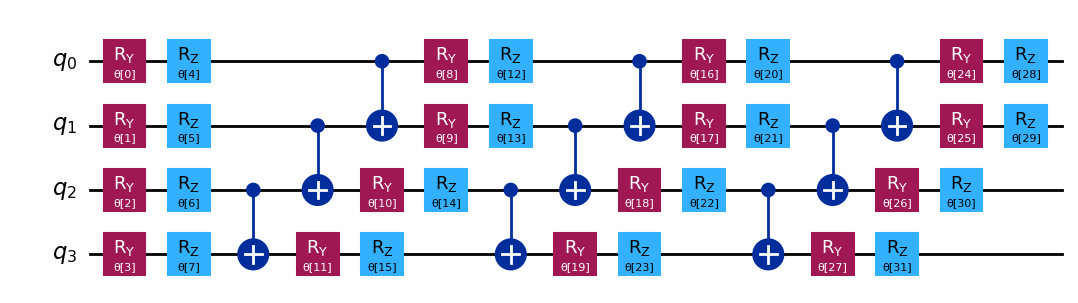

In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(hamiltonian.num_qubits).decompose()

ansatz.draw("mpl")

In [5]:
weights = np.arange(num_qubits, 0, -1)

print(weights)

[4 3 2 1]


In [6]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)],
}


def initialize_cost_history_dict():
    cost_history_dict["prev_vector"] = None
    cost_history_dict["iters"] = 0
    cost_history_dict["total_energy"] = []
    cost_history_dict["eigenstates_energies"] = [[] for _ in range(num_qubits)]

## Weighted sum of expectation values
$\text{SSVQE\_Cost}(\theta) = \sum_k w_k \langle \psi_k(\theta) | H | \psi_k(\theta) \rangle$

In [7]:
def ssvqe_cost_func(params, ansatz, hamiltonian, estimator, initial_states, weights):
    pubs = []

    for init_state in initial_states:
        full_circuit = init_state.compose(ansatz)
        pubs.append((full_circuit, [hamiltonian], [params]))

    result = estimator.run(pubs=pubs).result()
    energies = [r.data.evs[0] for r in result]

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["total_energy"].append(weighted_energy)

    for i in range(num_qubits):
        cost_history_dict["eigenstates_energies"][i].append(energies[i])

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")

    return weighted_energy

In [8]:
estimator = AerEstimator()
estimator.options.shots = 10000

In [9]:
params_init = np.random.rand(ansatz.num_parameters) * 2 * np.pi
initialize_cost_history_dict()

result = minimize(
    ssvqe_cost_func,
    params_init,
    args=(ansatz, hamiltonian, estimator, initial_states, weights),
    method="BFGS",
)

[Iter 1] Cost: 2.256764
[Iter 2] Cost: 2.256764
[Iter 3] Cost: 2.256764
[Iter 4] Cost: 2.256764
[Iter 5] Cost: 2.256764
[Iter 6] Cost: 2.256764
[Iter 7] Cost: 2.256764
[Iter 8] Cost: 2.256764
[Iter 9] Cost: 2.256764
[Iter 10] Cost: 2.256764
[Iter 11] Cost: 2.256764
[Iter 12] Cost: 2.256764
[Iter 13] Cost: 2.256764
[Iter 14] Cost: 2.256764
[Iter 15] Cost: 2.256764
[Iter 16] Cost: 2.256764
[Iter 17] Cost: 2.256764
[Iter 18] Cost: 2.256764
[Iter 19] Cost: 2.256764
[Iter 20] Cost: 2.256764
[Iter 21] Cost: 2.256764
[Iter 22] Cost: 2.256764
[Iter 23] Cost: 2.256764
[Iter 24] Cost: 2.256764
[Iter 25] Cost: 2.256764
[Iter 26] Cost: 2.256764
[Iter 27] Cost: 2.256764
[Iter 28] Cost: 2.256764
[Iter 29] Cost: 2.256764
[Iter 30] Cost: 2.256764
[Iter 31] Cost: 2.256764
[Iter 32] Cost: 2.256764
[Iter 33] Cost: 2.256764
[Iter 34] Cost: -5.657135
[Iter 35] Cost: -5.657135
[Iter 36] Cost: -5.657135
[Iter 37] Cost: -5.657135
[Iter 38] Cost: -5.657135
[Iter 39] Cost: -5.657135
[Iter 40] Cost: -5.657135
[I

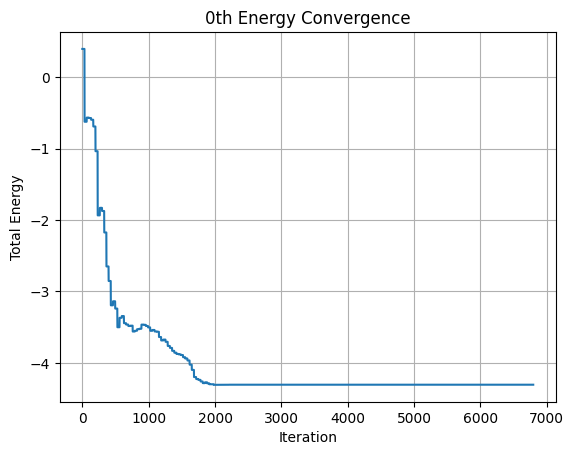

Converged Energy : -4.305244311631879


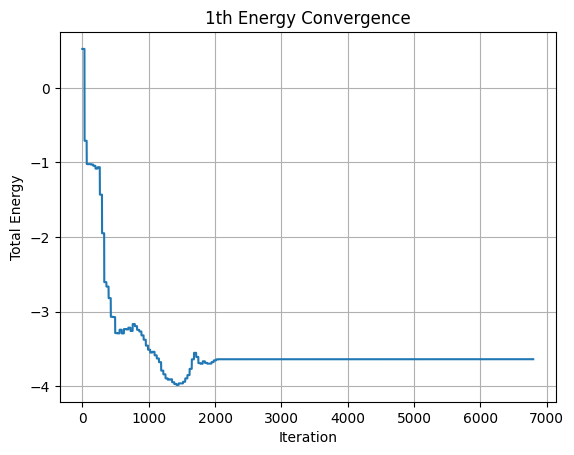

Converged Energy : -3.6399838128301414


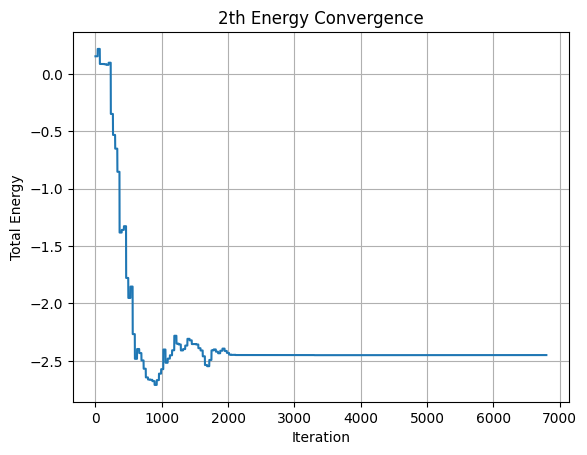

Converged Energy : -2.449858778944853


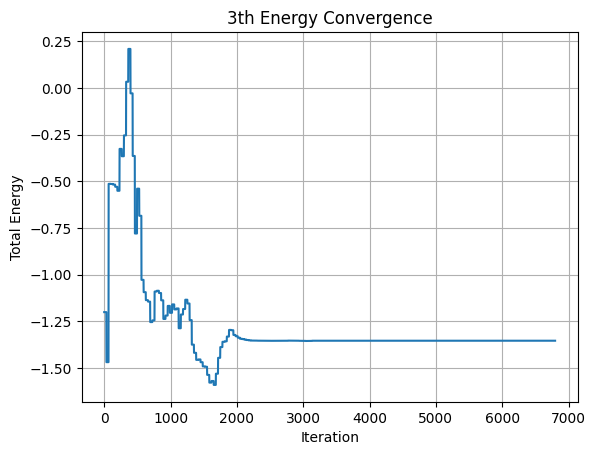

Converged Energy : -1.3529036825275567


In [10]:
for i in range(num_qubits):

    plt.plot(cost_history_dict["eigenstates_energies"][i])
    plt.xlabel("Iteration")
    plt.ylabel("Total Energy")
    plt.title(f"{i}th Energy Convergence")
    plt.grid()
    plt.show()

    iters = cost_history_dict["iters"] - 1
    converged_energy = cost_history_dict["eigenstates_energies"][i][iters]
    print(f"Converged Energy : {converged_energy}")